In [43]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

plt.rcParams.update({'font.size':12})

FILEDIR = '/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/'
vars = ['TMP2m', 'PRMSL']
seasons = ["DJF", "MAM", "SON", "JJA"]
var = vars[0]

# 20CRv3 background

In [44]:
tmp = xr.open_dataset(f'/home/ccorbella/scratch2_symboliclink/files/20CRv3_ensembles/ensmem.{var}.Europe/1806/{var}.1806_mem001_daymean_Europe.nc')
tmp2 = xr.open_dataset(f'/home/ccorbella/scratch2_symboliclink/files/20CRv3_ensembles/{var}.Europe.allmems/{var}.1806.Europe.allmems.nc')
tmp3 = xr.open_dataset(f'/home/ccorbella/scratch2_symboliclink/files/20CRv3_ensembles/{var}.Europe.allmems/{var}.Europe.allmems.allyears.nc')
tmp4 = xr.open_dataset(f'/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/data/{var}.Europe.allmems.anomalies.nc')

tmp4

<xarray.Dataset>
Dimensions:          (ensemble_member: 80, time: 5844, lat: 71, lon: 114)
Coordinates:
  * ensemble_member  (ensemble_member) int64 1 2 3 4 5 6 7 ... 75 76 77 78 79 80
  * time             (time) datetime64[ns] 1806-01-01T10:30:00 ... 1821-12-31...
  * lat              (lat) float64 79.65 78.95 78.25 77.54 ... 31.93 31.23 30.53
  * lon              (lon) float64 -29.53 -28.83 -28.12 ... 48.52 49.22 49.92
Data variables:
    TMP2m            (ensemble_member, time, lat, lon) float32 ...

In [45]:
tmpA = tmp.isel(time=0)[var]
tmp2A = tmp2.isel(time=0,ensemble_member=0)[var]
tmp3A = tmp3.isel(time=0,ensemble_member=0)[var]
tmp4A = tmp4.isel(time=0,ensemble_member=0)[var]


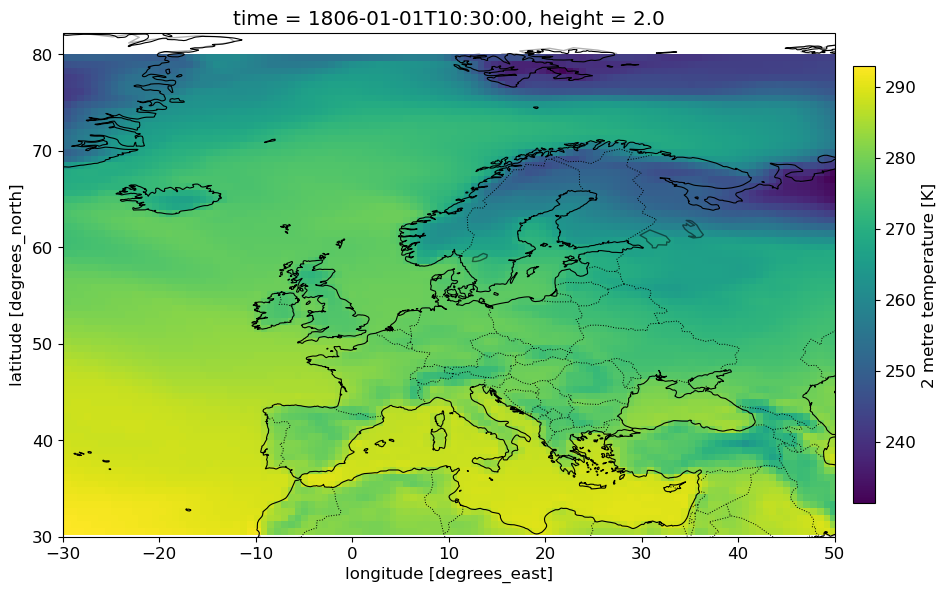

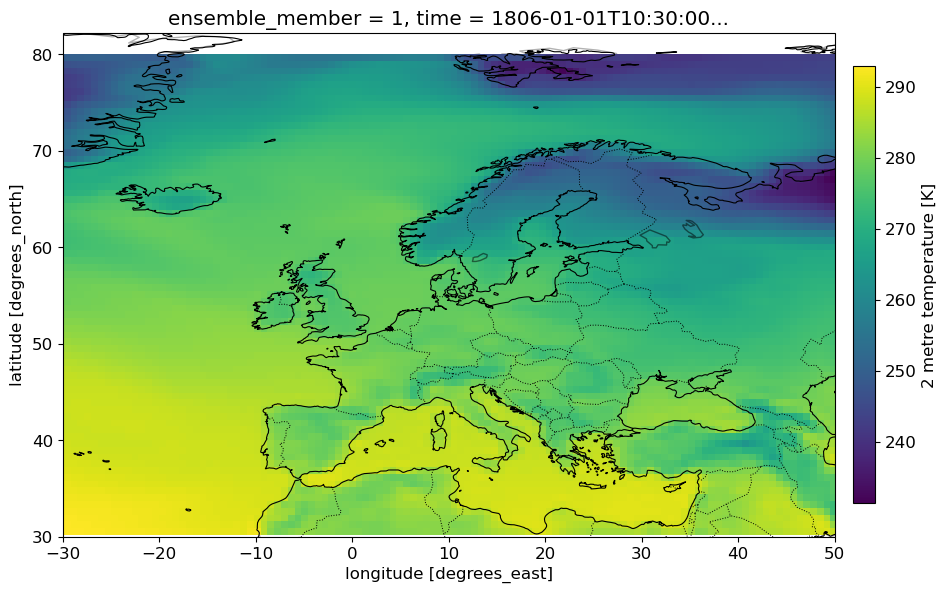

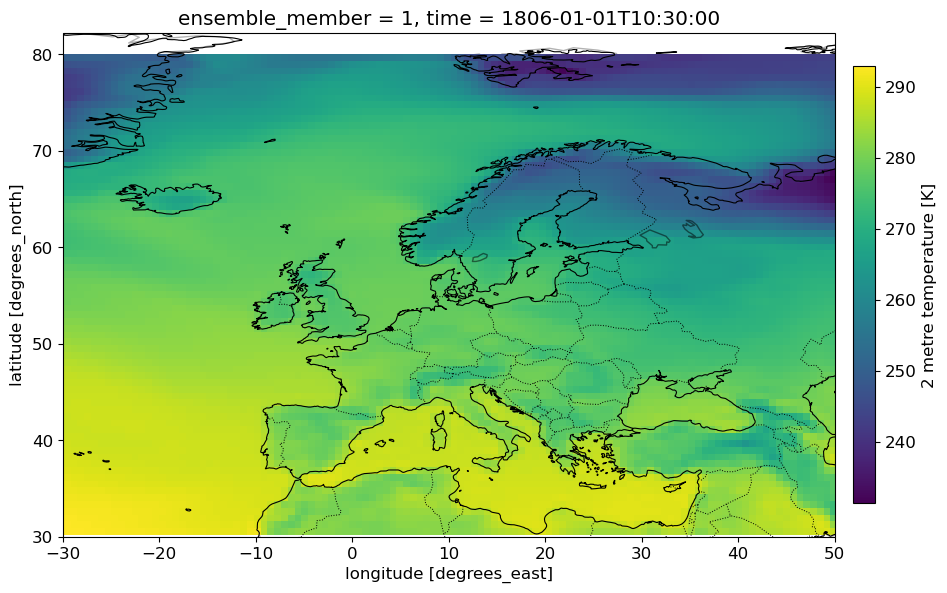

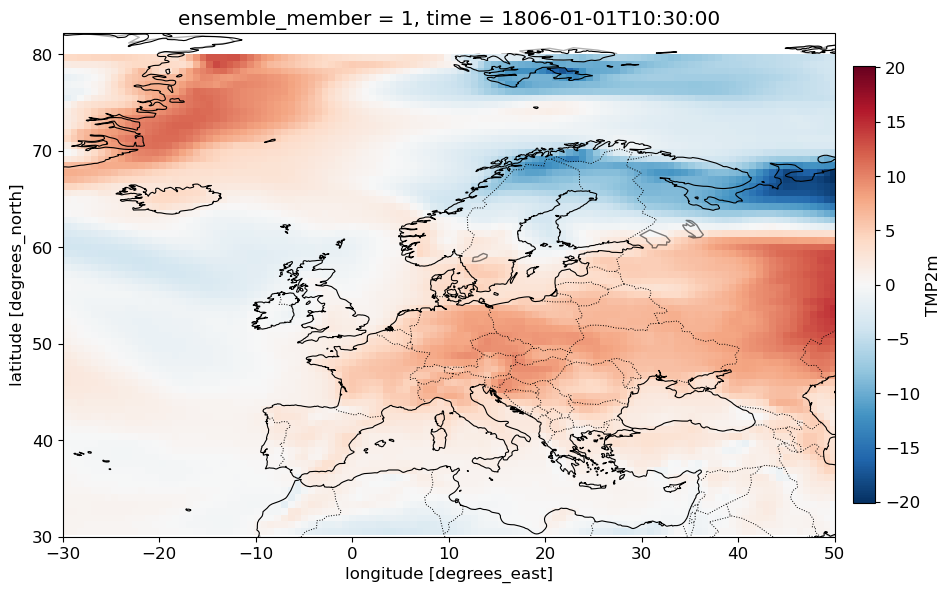

In [37]:
def plot_tmp(data):
    """Plot the spread data on a map."""
    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Plot the data
    data.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cbar_kwargs={
            'pad': 0.02,
            'shrink': 0.71,
            'aspect': 20,
        }
    )
    ax.set_extent([-30, 50, 30, 80])
    ax.coastlines(resolution='50m', linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.7)
    ax.add_feature(cfeature.LAND, facecolor='none', edgecolor='black', alpha=0.3)
    ax.add_feature(cfeature.LAKES, facecolor='none', edgecolor='black', alpha=0.5)

    xticks = range(-30, 51, 10)  # Longitude ticks
    yticks = range(30, 81, 10)   # Latitude ticks
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())

    plt.show()

plot_tmp(tmpA)
plot_tmp(tmp2A)
plot_tmp(tmp3A)
plot_tmp(tmp4A)

## Ensemble members

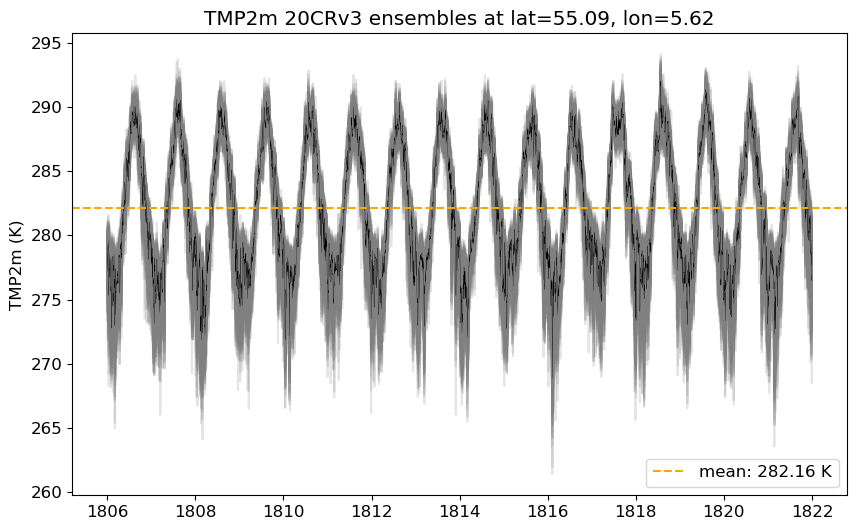

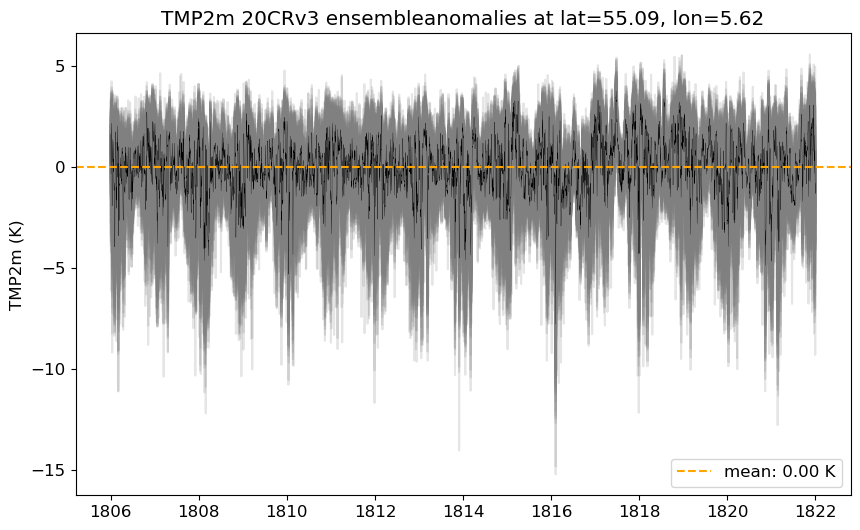

In [48]:
def plot_20CRcell(lat_index, lon_index, var, data, output_file, anomals=False):
    '''
    anomals is True if it's anomalies that we are plotting
    '''
    data_cell = data.sel(lat=data.lat[lat_index], lon=data.lon[lon_index])
    
    time = data['time']  # Access time coordinates
    
    # Extract data once to avoid repeated calls to `.values`
    ensemble_members = data_cell['ensemble_member'].data  # NumPy array
    data_cell = data_cell[var].values  # or .values for NumPy array

    fig = plt.figure(figsize=(10, 6))

    # Loop through ensemble members using pre-extracted data
    for i, ens in enumerate(ensemble_members):
        plt.plot(time.data, data_cell[i, :], alpha=0.2, color='gray')

    # Plot mean across ensemble members
    ens_mean = data_cell.mean(axis=0)
    plt.plot(time.data, ens_mean, color='black', linewidth=.2)

    all_mean = np.mean(ens_mean)
    units = 'K' if var=='TMP2m' else 'Pa'
    plt.axhline(all_mean, color='orange', linestyle='dashed',label=f'mean: {all_mean:.2f} {units}')

    anomal_text = 'anomalies' if anomals else 's'

    plt.legend(loc='lower right')

    plt.title(f'{var} 20CRv3 ensemble{anomal_text} at lat={data.lat[lat_index].values:.2f}, lon={data.lon[lon_index].values:.2f}')
    plt.ylabel(f'{var} ({units})')
    plt.savefig(output_file)
    plt.show()

plot_20CRcell(lat_index=35,lon_index=50, var=var, data=tmp3, anomals=False,
              output_file = f'/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/output/{var}_cell_ensmems_abs.png')
plot_20CRcell(lat_index=35,lon_index=50, var=var, data=tmp4, anomals=True,
              output_file=f'/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/output/{var}_cell_ensmems_anomalies.png')


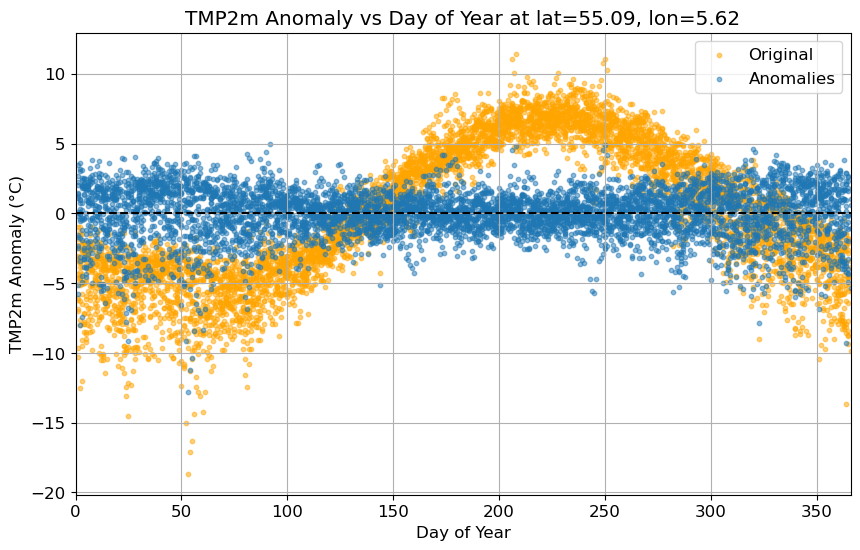

In [49]:
def plot_doy(data_bckgrd, data_anomals, ens_mem, lat_index, lon_index, var, output_file):    
    time_index = pd.to_datetime(data_anomals.time.values)

    # Extract the temperature anomaly data for the specific cell
    cell_bckgrd = data_bckgrd.sel(lat=data_bckgrd.lat[lat_index],
                                  lon=data_bckgrd.lon[lon_index],
                                  ensemble_member=ens_mem,
                                  )[var].values
    cell_anomals = data_anomals.sel(lat=data_anomals.lat[lat_index],
                                    lon=data_anomals.lon[lon_index],
                                    ensemble_member=ens_mem,
                                    )[var].values
    mymean=np.mean(cell_bckgrd)

    # scatter plot of temperature anomaly vs day of year
    plt.figure(figsize=(10, 6))
    plt.scatter(time_index.dayofyear,
                cell_bckgrd-mymean, alpha=0.5, color='orange',
                                    s=10, label='Original')
    plt.scatter(time_index.dayofyear, cell_anomals, alpha=0.5, s=10, label='Anomalies')
    units = '°C' if var=='TMP2m' else 'Pa'

    plt.xlabel('Day of Year')
    plt.ylabel(f'{var} Anomaly ({units})')
    plt.axhline(0, color='black', linestyle='dashed')
    plt.title(f'{var} Anomaly vs Day of Year at lat={data_bckgrd.lat[lat_index].values:.2f}, lon={data_bckgrd.lon[lon_index].values:.2f}')
    plt.grid(True)
    plt.legend()
    plt.xlim([0,366])
    plt.savefig(output_file)
    plt.show()

plot_doy(lat_index=35,lon_index=50, var=var, ens_mem=1, data_bckgrd=tmp3, data_anomals=tmp4,
         output_file = f'/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/output/{var}_anomals_DoY.png')

# Observations

## Pressure

In [3]:
var = 'PRMSL'
p_obs_data = pd.read_csv('/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/data/p_obs_data.csv')
p_obs_data = p_obs_data.iloc[1:,:] # first row is stupid geworden

p_obs_anomals = pd.read_csv('/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/data/p_obs_anomalies.csv') # period 1806-1821

/tmp/ipykernel_1540430/188419747.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  p_obs_anomals_resampled = p_obs_anomals.set_index('Date').resample('M').mean().reset_index()


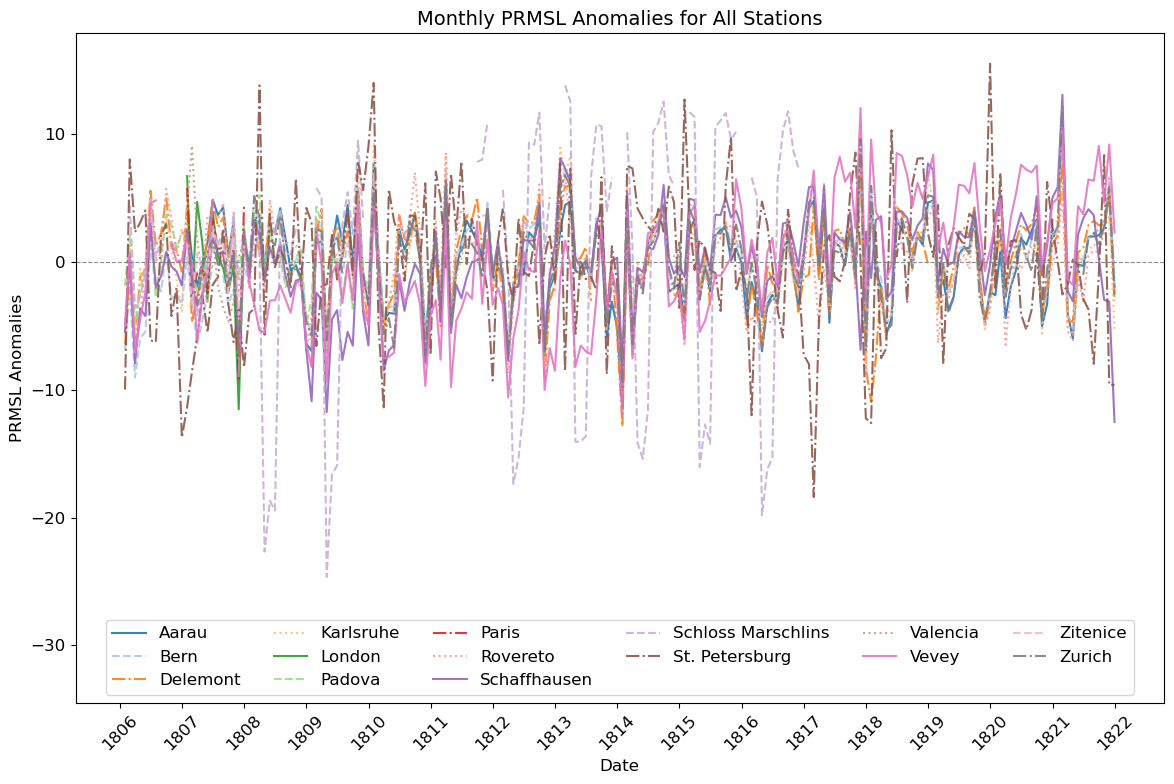

In [32]:
import matplotlib.dates as mdates


p_obs_anomals['Date'] = pd.to_datetime(p_obs_anomals['Date'])

# Resample or aggregate data (e.g., monthly mean)
p_monthly_means = p_obs_anomals.set_index('Date').resample('M').mean().reset_index()
#p_monthly_means = p_obs_anomals

# Set up the figure
plt.figure(figsize=(14, 8))
ax = plt.gca()

# Define color map and linestyles
colors = plt.cm.tab20(np.arange(len(p_monthly_means.columns[1:])))
linestyles = ['-', '--', '-.', ':']

# Plot each station
legend_entries = []
for i, station_name in enumerate(p_monthly_means.columns[1:]):
    color = colors[i]  # Cycle through colors
    linestyle = linestyles[i % len(linestyles)]  # Cycle through linestyles
    
    ax.plot(
        p_monthly_means['Date'], 
        p_monthly_means[station_name], 
        label=station_name, 
        color=color, 
        linestyle=linestyle, 
        alpha=0.9
    )
    
# Add a horizontal line at 0
ax.axhline(0, color='gray', linestyle='dashed', linewidth=0.8, alpha=0.9)

# Adjust x-axis ticks and format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

# Add legend
ax.legend(loc='lower center', ncol=6, fontsize=12)

# Add a text box with details for all stations
text_box = '\n'.join(legend_entries)
props = dict(boxstyle='round', facecolor='white')
ax.text(1.05, 0.5, text_box, transform=ax.transAxes, fontsize=9, 
        verticalalignment='center', bbox=props)

# Customize axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel(f'{var} Anomalies')
ax.set_title(f'Monthly {var} Anomalies for All Stations', fontsize=14)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave room for text box
plt.savefig(f'/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/output/{var}_obs_anomalies.png')
plt.show()


ConversionError: Failed to convert value(s) to axis units: Timestamp('1806-01-01 00:00:00')

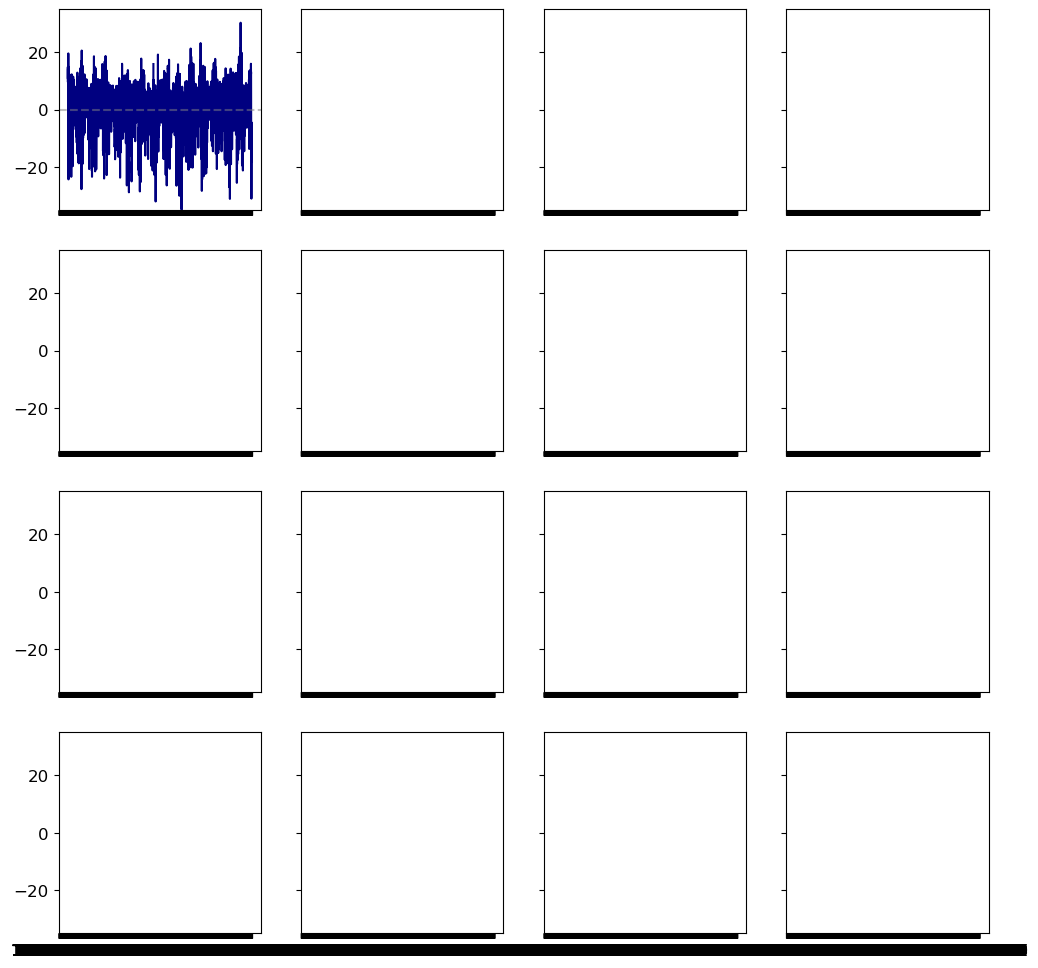

In [35]:
# Set up figure and axis arrays
fig, axs = plt.subplots(4, 4, figsize=(12, 12), sharex=True, sharey=True)

# Ensure dates are in datetime format
p_obs_anomals['Date_datetime'] = pd.to_datetime(p_obs_anomals['Date'])

# Convert to numeric values for Matplotlib
min_date = mdates.date2num(p_obs_anomals['Date_datetime'].min())
max_date = mdates.date2num(p_obs_anomals['Date_datetime'].max())

# Flatten the array of axes for easier iteration
axs = axs.flatten()

# Define a date locator for every 30 years
locator = mdates.YearLocator(base=30)  
formatter = mdates.DateFormatter('%Y') 

colors = plt.cm.gist_ncar(np.linspace(0,1, p_obs_anomals.shape[0]))

# Plot each station's data in its own subplot
for i, ax in enumerate(axs): # i ranges from [0, 20]
    if i >= p_obs_anomals.shape[1]-1:  # Ensure we don't go out of bounds
        ax.set_visible(False)
        continue # doesn't do the rest of the for loop
 
    station_name = p_obs_anomals.columns[i+1]

    ax.plot(p_obs_anomals['Date'], p_obs_anomals[station_name], alpha=1, color=colors[i])
    ax.axhline(alpha=.5, color='gray', linestyle='dashed')
    
    ## count how many are above zero and how many below zero
    # gt_zero = np.sum(p_obs_anomals[station_name]>0)
    # lt_zero = np.sum(p_obs_anomals[station_name]<0)
    # gt_zero_perc = gt_zero/(gt_zero + lt_zero) * 100
    # lt_zero_perc = lt_zero/(gt_zero + lt_zero) * 100
    
    ax.set_ylim(-35, 35)
    ax.set_xlim(min_date, max_date)
    
    # Remove y-axis labels and ticks for all but the first column
    if i % 4 != 0:
        ax.yaxis.label.set_visible(False)
        ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=False, labelright=False)
    
    # Hide x-axis labels for all but the bottom row
    if i < 12:  # Rows 0-2 should have no x labels
        ax.set_xticklabels([])
    else:
        ax.xaxis.set_major_locator(locator)  # Major ticks every 30 years
        ax.xaxis.set_major_formatter(formatter)  # Format as 'YYYY'
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

    ax.set_ylabel(r'PRMSL')
    ax.set_title(station_name)  # Use the station name as title

    # Add textbox with gt_zero and lt_zero values
    # text = f'{gt_zero} ({int(gt_zero_perc)}%); {lt_zero} ({int(lt_zero_perc)}%)'
    # ax.text(0.95, 0.05, text, transform=ax.transAxes, fontsize=9,
    #         horizontalalignment='right', verticalalignment='bottom')

plt.subplots_adjust(hspace=0.3, wspace=0.1)
fig.suptitle('Pressure Observation Anomalies', y=1.01, fontsize=14)
plt.savefig('/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/output/p_obs_anomalies.png')
plt.show()

## Temperature

In [97]:
var = 'TMP2m'
t_obs_anomalies = pd.read_csv('/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/data/TMP2m_obs_anomalies.txt', 
                              delim_whitespace=True, header=None)

t_obs_anomalies["Date"] = pd.to_datetime(p_obs_anomals["Date"])
t_obs_anomalies.set_index('Date', inplace=True)
t_monthly_means = t_obs_anomalies.resample('M').mean().reset_index()

t_obs_metadata = pd.read_csv('/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/data/TMP2m_obs_metadata.csv')

# remove IMPROVE St Petersburg station as I didn't assimilate it
t_obs_metadata = t_obs_metadata[t_obs_metadata['station'] != 'IMPROVE_StPetersburg']

/tmp/ipykernel_1540430/3188350768.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  t_obs_anomalies = pd.read_csv('/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/data/TMP2m_obs_anomalies.txt',
/tmp/ipykernel_1540430/3188350768.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  t_monthly_means = t_obs_anomalies.resample('M').mean().reset_index()


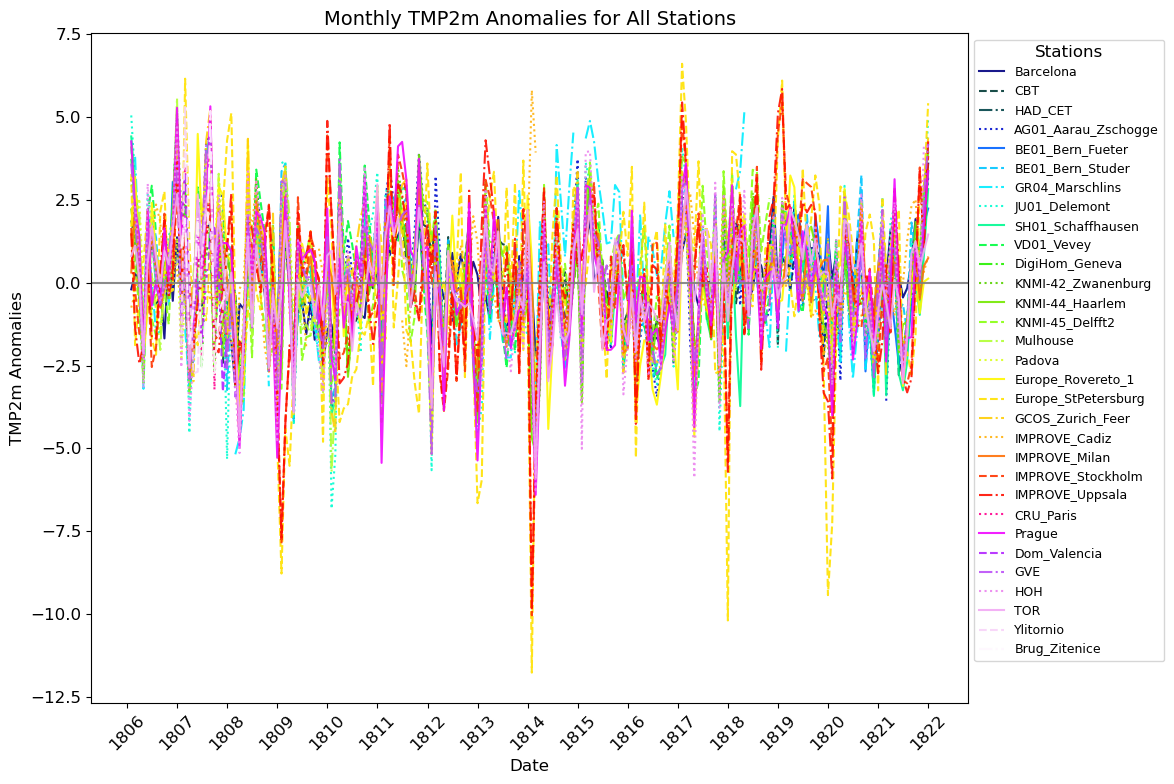

In [121]:
plt.figure(figsize=(14, 8))
ax = plt.gca()

# Define color map and linestyles
colors = plt.cm.gist_ncar(np.linspace(0,1, t_obs_metadata.shape[0]))
linestyles = ['-', '--', '-.', ':']

# Plot each station
for i, station_name in enumerate(t_obs_metadata['station']):
    linestyle = linestyles[i % len(linestyles)]  # Cycle through linestyles
    
    ax.plot(
        t_monthly_means['Date'], 
        t_monthly_means[i], 
        label=station_name, 
        color=colors[i], 
        linestyle=linestyle, 
        alpha=0.9
    )

# Add a horizontal line at 0
plt.legend(
    loc='upper left',         # Anchor the legend in the upper left corner
    bbox_to_anchor=(1, 1),    # Position the legend outside the plot area
    title="Stations",         # Add a title to the legend
    fontsize=9                # Adjust font size for better readability
)

ax.axhline(0, linestyle='-', color='gray', alpha=0.9)

# Adjust x-axis ticks and format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

# Add a text box with details for all stations
text_box = '\n'.join(legend_entries)
props = dict(boxstyle='round', facecolor='white')
ax.text(1.05, 0.5, text_box, transform=ax.transAxes, fontsize=9, 
        verticalalignment='center', bbox=props)

# Customize axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel(f'{var} Anomalies')
ax.set_title(f'Monthly {var} Anomalies for All Stations', fontsize=14)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave room for text box
plt.savefig(f'/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/output/{var}_obs_anomalies.png')
plt.show()